In [1]:
from matplotlib import pyplot as plt
%matplotlib widget
import numpy as np
import torch
def psychometric_func(x, w_2=None, b_2=None, real_psych_gamma=None, real_psych_lambda=None):
    # if np.ndim(x) == 1:
        # x = x.reshape((-1, 1))
    #       return expit(np.dot(w_2, x.T) + b_2)
    #       print ("x has shape", x.shape)
    #       print ("w_2 has shape", w_2)
    return real_psych_gamma + (1. - real_psych_gamma - real_psych_lambda) * torch.sigmoid(torch.matmul(torch.tensor(x), torch.tensor(w_2)) + torch.tensor(b_2))


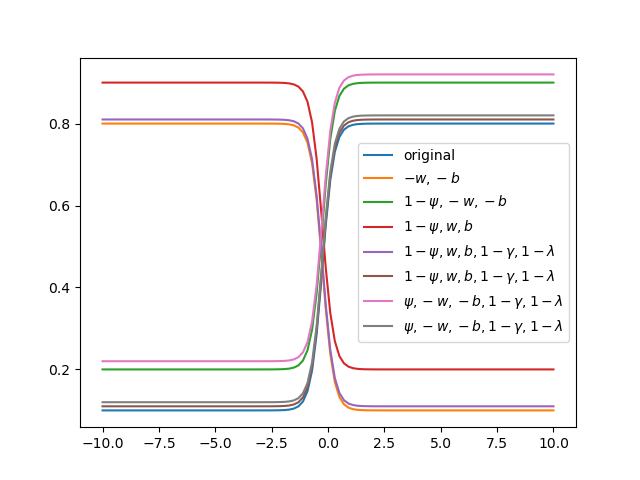

In [13]:
t = np.linspace(-10, 10,  100)
w = np.asarray([4.])
b = np.asarray(1.)
real_psych_gamma = .1
real_psych_lambda = .2
fig, ax = plt.subplots()
ax.plot(t, psychometric_func(t.reshape((-1, 1)), w, b, real_psych_gamma=real_psych_gamma, real_psych_lambda=real_psych_lambda).detach().numpy(), label='original')
ax.plot(t, psychometric_func(t.reshape((-1, 1)), -w, -b, real_psych_gamma=real_psych_gamma, real_psych_lambda=real_psych_lambda).detach().numpy(), label= r'$-w, -b$')
ax.plot(t, 1 - psychometric_func(t.reshape((-1, 1)), -w, -b, real_psych_gamma=real_psych_gamma, real_psych_lambda=real_psych_lambda).detach().numpy(), label=r'$1-\psi, -w, -b$')
ax.plot(t, 1 - psychometric_func(t.reshape((-1, 1)), w, b, real_psych_gamma=real_psych_gamma, real_psych_lambda=real_psych_lambda).detach().numpy(), label=r'$1-\psi, w, b$')
ax.plot(t, 1.01 - psychometric_func(t.reshape((-1, 1)), -w, -b, real_psych_gamma=1-real_psych_gamma, real_psych_lambda=1-real_psych_lambda).detach().numpy(), label=r'$1-\psi, w, b, 1-\gamma, 1-\lambda$')
ax.plot(t, 1.01 - psychometric_func(t.reshape((-1, 1)), w, b, real_psych_gamma=1-real_psych_gamma, real_psych_lambda=1-real_psych_lambda).detach().numpy(), label=r'$1-\psi, w, b, 1-\gamma, 1-\lambda$')
ax.plot(t, .02 + psychometric_func(t.reshape((-1, 1)), -w, -b, real_psych_gamma=1-real_psych_gamma, real_psych_lambda=1-real_psych_lambda).detach().numpy(), label=r'$\psi, -w, -b, 1-\gamma, 1-\lambda$')
ax.plot(t, .02 + psychometric_func(t.reshape((-1, 1)), -w, -b, real_psych_gamma=1-real_psych_lambda, real_psych_lambda=1-real_psych_gamma).detach().numpy(), label=r'$\psi, -w, -b, 1-\gamma, 1-\lambda$')


plt.legend()

plt.show()

In [16]:
np.exp(1e-23)

1.0

In [22]:
0.7465 / 0.875

0.8531428571428572

In [ ]:
import torchvision.models as models

# List of model functions in torchvision that support pretrained weights
model_functions = [
    'alexnet', 'vgg16', 'vgg19', 'resnet18', 'resnet34', 'resnet50',
    'resnet101', 'resnet152', 'squeezenet1_0', 'squeezenet1_1', 'densenet121',
    'densenet169', 'densenet201', 'densenet161', 'inception_v3', 'googlenet',
    'shufflenet_v2_x1_0', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small',
    'resnext50_32x4d', 'resnext101_32x8d', 'wide_resnet50_2', 'wide_resnet101_2',
    'mnasnet1_0', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2',
    'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6',
    'efficientnet_b7'
]

for model_name in model_functions:
    try:
        print(f"Attempting to download {model_name}...")
        model_function = getattr(models, model_name)
        model = model_function(pretrained=True)
        print(f"Successfully downloaded {model_name}.")
    except AttributeError:
        print(f"Model function {model_name} does not exist in torchvision.models.")
    except Exception as e:
        print(f"An error occurred while downloading {model_name}: {e}")

In [29]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModel
import pickle
def read_fake_reviews(data_path, embedding='TF-IDF'):
    # Load the TSV data
    data = pd.read_csv(os.path.join(data_path, 'op_spam.human_judgements.tsv'), sep='\t', header=None, encoding='utf-8')
    data.columns = ['Label', 'Hotel_Name', 'S1', 'S2', 'S3', 'Review_Text']

    # Process labels
    real_label_dict = {'T': 0, 'F': 1}  # Assuming 'T' for true (non-fake) and 'F' for fake
    y = data['Label'].map(real_label_dict).values

    # Define LePU labeling based on your specific criteria
    # This is an example assuming 'S1', 'S2', 'S3' are sources with binary judgments
    l = (data[['S1', 'S2', 'S3']].values == 'F').any(axis=1).astype(int)

    X_text = data['Review_Text'].values

    if embedding == 'TF-IDF':
        vectorizer = TfidfVectorizer(max_features=512)
        main_X = vectorizer.fit_transform(X_text).toarray()
    elif embedding == 'BioBERT':
        bert_pickle = os.path.join(data_path, 'fake_reviews_BioBERT.pkl')
        if not os.path.isfile(bert_pickle):
            tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
            model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")
            embeddings = []
            for text in X_text:
                inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding="max_length")
                with torch.no_grad():
                    outputs = model(**inputs)
                embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
            main_X = np.array(embeddings)
            with open(bert_pickle, 'wb') as f:
                pickle.dump([main_X, y, l], f)
        else:
            with open(bert_pickle, 'rb') as f:
                main_X, y, l = pickle.load(f)
    else:
        raise ValueError("Unsupported embedding type. Use 'TF-IDF' or 'BioBERT'.")

    return main_X, y, l

# Example usage
data_path = '/Users/naji/Downloads/fake_reviews-selected-2'  # Specify the correct path to your data directory
main_X, main_y, main_l = read_fake_reviews(data_path, embedding='TF-IDF')

In [31]:
main_y

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1])